In [3]:
import json
import numpy as np
import keras.backend as K
from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector
import soundfile
import librosa
import matplotlib.pyplot as plt

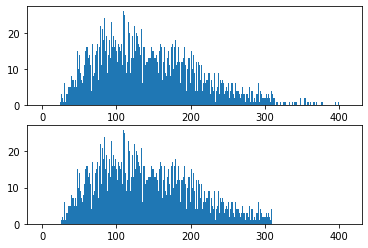

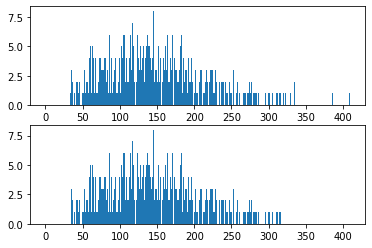

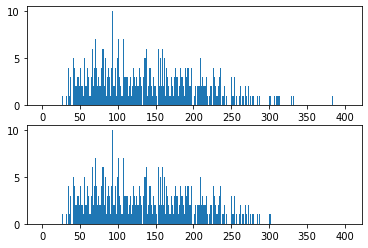

In [181]:
train_path = 'Downsampled/en/MFCC_json_files/MFCC_train.json'
test_path = 'Downsampled/en/MFCC_json_files/MFCC_test.json'
validate_path = 'Downsampled/en/MFCC_json_files/MFCC_validate.json'

def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
    
    MFCC_dataset = []
    for key in json_data:
        MFCC_array = np.array(json_data[key])
        MFCC_dataset.append(MFCC_array.T)
    return MFCC_dataset

def get_max_frame_length(MFCC_dataset):
    return max([MFCC.shape[0] for MFCC in MFCC_dataset])

def data_length_histogram(MFCC_dataset, cutoff, plot=False):
    cutoff = cutoff/100 if cutoff > 1 else cutoff
    lengths = [len(mfcc) for mfcc in MFCC_dataset]
    binlen = range(max(lengths)+1)
    total = len(lengths)
    n_to_remove = int((1 - cutoff) * total)
    
    if plot:
        plt.subplot(2, 1, 1)
        plt.hist(lengths, bins=binlen)
    
    for _ in range(n_to_remove):
        lengths = [len(mfcc) for mfcc in MFCC_dataset]
        u_list = np.array(np.unique(np.array(lengths), return_counts=True, return_index=True)).T
        u_list = np.array(sorted(u_list, key=lambda x: x[0]))
        if u_list[0][2] < u_list[-1][2]:
            MFCC_dataset = np.delete(MFCC_dataset, u_list[0][1])
        else:
            MFCC_dataset = np.delete(MFCC_dataset, u_list[-1][1])
    
    if plot:
        plt.subplot(2, 1, 2)
        plt.hist(lengths, bins=binlen)
        plt.show()
        
    return MFCC_dataset

def pad_data(MFCC_dataset, number_of_frames):
    padded_MFCC_dataset = []
    for MFCC in MFCC_dataset:
        new_MFCC = np.pad(MFCC, ((number_of_frames-MFCC.shape[0], 0), (0, 0)), 'constant')
        padded_MFCC_dataset.append(new_MFCC)
    return np.array(padded_MFCC_dataset)

MFCC_train_set = load_data(train_path)
MFCC_test_set = load_data(test_path)
MFCC_validate_set = load_data(validate_path)

MFCC_train_set = data_length_histogram(MFCC_train_set, 98, plot=True)
MFCC_test_set = data_length_histogram(MFCC_test_set, 98, plot=True)
MFCC_validate_set = data_length_histogram(MFCC_validate_set, 98, plot=True)

In [176]:
max_frames_train = get_max_frame_length(MFCC_train_set)
max_frames_test = get_max_frame_length(MFCC_test_set)
max_frames_validate = get_max_frame_length(MFCC_validate_set)

new_number_of_frames = max([max_frames_train, max_frames_test, max_frames_validate])

padded_MFCC_train_set = pad_data(MFCC_train_set, new_number_of_frames)
padded_MFCC_test_set = pad_data(MFCC_test_set, new_number_of_frames)
padded_MFCC_validate_set = pad_data(MFCC_validate_set, new_number_of_frames)

In [178]:
padded_MFCC_train_set.shape

(2799, 315, 12)

In [7]:
batch_size = 1
epochs = 10
latent_dim = 150
input_dim = 12
timesteps = new_number_of_frames

inputs = Input(shape=(input_dim, timesteps))
encoded = LSTM(latent_dim)(inputs)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)

sequence_autoencoder = Model(inputs, decoded)
sequence_autoencoder.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [8]:
sequence_autoencoder.fit(padded_MFCC_train_set,
                         padded_MFCC_train_set,
                         batch_size=batch_size,
                         epochs=epochs)

W0515 10:41:11.170021 140391068020864 deprecation.py:323] From /home/chris/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0515 10:41:12.178872 140391068020864 deprecation_wrapper.py:119] From /home/chris/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/10
3192/3192 [==============================] - 509s 159ms/step - loss: -1996.7381
Epoch 2/10
3192/3192 [==============================] - 507s 159ms/step - loss: -2056.6232
Epoch 3/10
3192/3192 [==============================] - 1674s 524ms/step - loss: -2052.1707
Epoch 4/10
3192/3192 [==============================] - 507s 159ms/step - loss: -2085.7858
Epoch 5/10
3192/3192 [==============================] - 508s 159ms/step - loss: -2085.7869
Epoch 6/10
3192/3192 [==============================] - 508s 159ms/step - loss: -2085.7869
Epoch 7/10
3192/3192 [==============================] - 515s 161ms/step - loss: -2085.7869
Epoch 8/10
3192/3192 [==============================] - 510s 160ms/step - loss: -2085.7869
Epoch 9/10
3192/3192 [==============================] - 509s 159ms/step - loss: -2085.7869
Epoch 10/10
3192/3192 [==============================] - 508s 159ms/step - loss: -2085.7869


In [55]:
prediction = sequence_autoencoder.predict(padded_MFCC_test_set)

In [57]:
wav_signal = librosa.feature.inverse.mfcc_to_audio(prediction[0])
soundfile.write('test_sound.wav', wav_signal, 22050)